In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras 
from scipy.stats import entropy
import sys
sys.path.append('..')
sys.path.append('../odcd/cd/')
sys.path.append('../odcd/utils/')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
import matplotlib.pyplot as plt
import model_symmetries as vsf
%matplotlib inline

from skmultiflow.drift_detection.adwin import ADWIN

import streaming_sim_test as sst
from importlib import reload

import colorama
from colorama import Fore, Style

Using TensorFlow backend.


In [2]:
def prepare_data_mnist(permute=False, perm_features=50, fashion=False):
    
    if fashion:
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    else:
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    print('x_train shape:', X_train.shape, 'y_train shape:', y_train.shape)

    # define train and test set
    np.random.seed(0)
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    X_train = np.reshape(X_train, X_train.shape + (1,))
    X_test = np.reshape(X_test, X_test.shape + (1,))
    print('x_train shape:', X_train.shape, 'x_test shape:', X_test.shape)
    
    if not permute:
        idxs_train_0_5 = np.where((y_train == 5) | (y_train == 4) | (y_train == 3) | 
                            (y_train == 2) | (y_train == 1) | (y_train == 0))
        idxs_test_0_5 = np.where((y_test == 5) | (y_test == 4) | (y_test == 3) | 
                            (y_test == 2) | (y_test == 1) | (y_test == 0))

        idxs_train_6_9 = np.where((y_train == 6) | (y_train == 7) | (y_train == 8) | 
                            (y_train == 9))
        idxs_test_6_9 = np.where((y_test == 6) | (y_test == 7) | (y_test == 8) | 
                            (y_test == 9))

        print(idxs_train_0_5[0].shape)
        print(idxs_test_0_5[0].shape)

        X_train_0_5 = X_train[idxs_train_0_5[0]]
        y_train_0_5 = y_train[idxs_train_0_5[0]]

        X_test_0_5 = X_test[idxs_test_0_5[0]]
        y_test_0_5 = y_test[idxs_test_0_5[0]]
    
        X_6_9 = X_test[idxs_test_6_9[0]]
        y_6_9 = y_test[idxs_test_6_9[0]]

        y_train_0_5 = tf.keras.utils.to_categorical(y_train_0_5)
        y_test_0_5 = tf.keras.utils.to_categorical(y_test_0_5)
        y_6_9 = tf.keras.utils.to_categorical(y_6_9)
    
        y_6_9 = np.delete(y_6_9, np.where(~y_6_9.any(axis=0)), axis=1)
        print(X_train_0_5.shape, y_train_0_5.shape)
        print(X_test_0_5.shape, y_test_0_5.shape)
        print(X_6_9.shape, y_6_9.shape)
    
    
        return X_train_0_5, y_train_0_5, X_test_0_5, y_test_0_5, X_6_9, y_6_9 
    else:
        mapp = {(28 * i) + j: [i, j]  for i in range(28) for j in range(28)}
        perm_1 = np.random.permutation(range(28 * 28))[:perm_features]
        perm_2 = np.random.permutation(range(28 * 28))[:perm_features]
        X_cd = X_test.copy()
        for t in zip(perm_1, perm_2):
            X_cd[:, mapp[t[0]][0], mapp[t[0]][1], :] = X_cd[:, mapp[t[1]][0], mapp[t[1]][1], :]
        y_cd = y_test
        
        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)
        y_cd = tf.keras.utils.to_categorical(y_cd)
        
        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
        print(X_cd.shape, y_cd.shape)
        return X_train, y_train, X_test, y_test, X_cd, y_cd

In [3]:
# define cnn model
def model_mnist(nb_classes=10):
    x_in = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x_out = tf.keras.layers.Dense(nb_classes, activation='softmax')(x)

    cnn = tf.keras.models.Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn


# Data Prep

In [7]:
X_train, y_train, X_test, y_test, X_cd, y_cd = prepare_data_mnist(permute=True, 
                                                                  perm_features=50, 
                                                                  fashion=True)

x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)
(10000, 28, 28, 1) (10000, 10)


Sample instance from the MNIST data set.


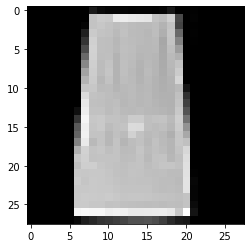

In [8]:
idx = 42
x = X_test[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

Sample instance from the MNIST data set.


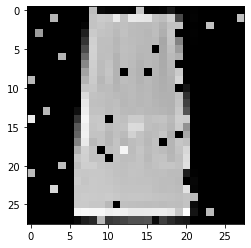

In [9]:
x = X_cd[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

# Train model

In [12]:
clf = model_mnist(nb_classes=10)

In [13]:
train = True
if train:
    clf.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
else:
    clf = tf.keras.models.load_model('cnn.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.5529 - acc: 0.7967 - val_loss: 0.3734 - val_acc: 0.8665
Epoch 2/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.3874 - acc: 0.8588 - val_loss: 0.3171 - val_acc: 0.8789
Epoch 3/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.3462 - acc: 0.8734 - val_loss: 0.2977 - val_acc: 0.8902
Epoch 4/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.3186 - acc: 0.8823 - val_loss: 0.2995 - val_acc: 0.8857
Epoch 5/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.3045 - acc: 0.8881 - val_loss: 0.2824 - val_acc: 0.8957
Epoch 6/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.2915 - acc: 0.8919 - val_loss: 0.2589 - val_acc: 0.9042
Epoch 7/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.2827 - acc: 0.8961 - val_loss: 0.2562 -

### Evaluate

In [14]:
print('Train')
sst.evaluate(clf, X_train, y_train)
print('Test')
sst.evaluate(clf, X_test, y_test)
print('cd')
sst.evaluate(clf, X_cd, y_cd)

Train
Accuracy: 0.934
Confusion matrix: [[5458    1   61   94    7    0  608    0    2    0]
 [   4 5965    1   27    7    0    4    0    1    0]
 [  69    2 5541   30  385    0  415    0    2    0]
 [  85   25   39 5623   98    0   92    0    1    0]
 [   8    1  204  137 5265    0  321    0   14    0]
 [   0    0    0    0    0 5912    0    8    1    8]
 [ 370    4  154   87  238    1 4554    0   14    0]
 [   0    0    0    0    0   73    0 5877    1  111]
 [   6    2    0    2    0    1    6    1 5964    0]
 [   0    0    0    0    0   13    0  114    0 5881]]
Test
Accuracy: 0.9106
Confusion matrix: [[884   0  20  22   0   0 119   0   1   0]
 [  0 982   2   8   1   0   1   0   1   0]
 [ 18   0 900  10  92   0  86   0   2   0]
 [ 16   9   7 901  23   0  25   0   4   0]
 [  3   3  32  23 837   0  67   0   5   0]
 [  1   0   0   0   0 975   0   1   2   3]
 [ 74   4  39  35  47   0 697   0   0   1]
 [  0   0   0   0   0  19   0 977   0  28]
 [  4   2   0   1   0   0   5   0 985   0]
 [

# Symmetries

In [15]:
vae = vsf.VaeSymmetryFinderConv(clf, input_shape=(28, 28, 1), rgb_filters=1,
                            output_shape=(10, ), 
                            intermediate_dim=256, 
                            latent_dim=8)

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 14, 14, 64)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 128)    73856       dropout_6[0][0]                  
__________________________________________________________________________________________________
dropou

In [16]:
vae.fit(X_train, x_test=X_test, epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 172us/step - loss: 0.9639 - val_loss: 0.2333
Epoch 2/10
60000/60000 [==============================] - 9s 151us/step - loss: 0.3114 - val_loss: 0.1491
Epoch 3/10
60000/60000 [==============================] - 9s 151us/step - loss: 0.2419 - val_loss: 0.0986
Epoch 4/10
60000/60000 [==============================] - 9s 150us/step - loss: 0.2069 - val_loss: 0.0830
Epoch 5/10
60000/60000 [==============================] - 9s 150us/step - loss: 0.1927 - val_loss: 0.0726
Epoch 6/10
60000/60000 [==============================] - 9s 151us/step - loss: 0.1813 - val_loss: 0.0710
Epoch 7/10
60000/60000 [==============================] - 9s 151us/step - loss: 0.1712 - val_loss: 0.0601
Epoch 8/10
60000/60000 [==============================] - 9s 151us/step - loss: 0.1684 - val_loss: 0.0620
Epoch 9/10
60000/60000 [==============================] - 9s 150us/step - loss: 0.1650 - val_loss: 0.

In [17]:
vae.save(arch_path='vae_arch_mnist.json', weights_path='vae_weights_mnist.h5')

In [18]:
vae_loaded = vsf.load_vae(arch_path='vae_arch_mnist.json', weights_path='vae_weights_mnist.h5')

Loaded model from disk


# Stream

In [23]:
# Symmetry signal
X_train_perm = np.random.permutation(X_train)
X_test_perm = np.random.permutation(X_test)
X_cd_perm = np.random.permutation(X_cd)

amp = 0.5
kl_train = vae_loaded.signal(X_train_perm, amp=amp)
kl_test = vae_loaded.signal(X_test_perm, amp=amp)
kl_cd = vae_loaded.signal(X_cd_perm, amp=amp)

baseline_std_plus = kl_train.mean() + kl_train.std()
baseline_std_minus = kl_train.mean() - kl_train.std()

kl_concat = np.concatenate((kl_test, kl_cd))
tr = kl_test.shape[0]

### Sudden drift

In [24]:
df = sst.make_data_stream(kl_concat, agg='mean')

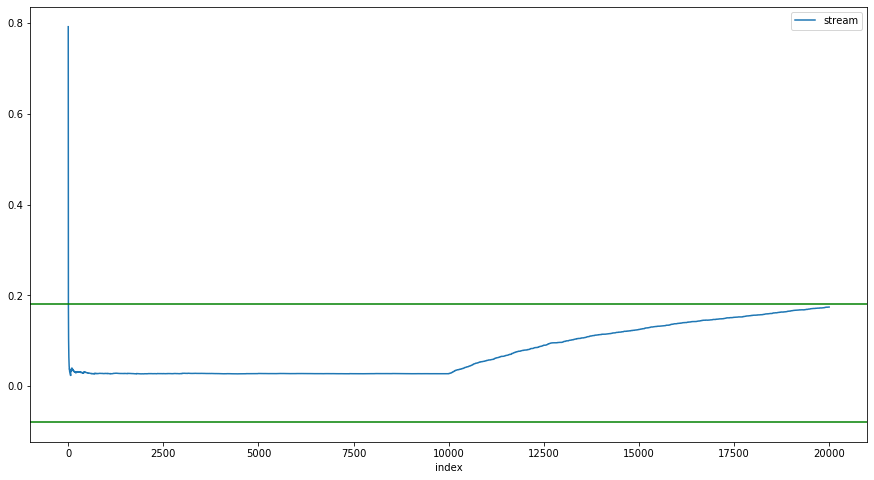

In [27]:
ax = df.plot(x='index', y='stream', figsize=(15,8))
ax.axhline(baseline_std_plus / amp, c='g')
ax.axhline(baseline_std_minus / amp, c='g')

In [26]:
adwin = ADWIN(delta=0.002)
data_stream = df['stream']
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < tr:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

/home/Gigio/anaconda3/lib/python3.6/site-packages/skmultiflow/drift_detection/adwin.py:361: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m


Change detected in data: 0.05184978706798887 - at index: 10783
Change detected in data: 0.07937906256956895 - at index: 11999
Change detected in data: 0.07949034213227814 - at index: 12031
Change detected in data: 0.08003249336470068 - at index: 12063
Change detected in data: 0.08249392573768109 - at index: 12159
Change detected in data: 0.08316020252100097 - at index: 12223
Change detected in data: 0.08457621357999764 - at index: 12255
Change detected in data: 0.08714671016859574 - at index: 12383
Change detected in data: 0.09225593336222067 - at index: 12607
Change detected in data: 0.09617304862756819 - at index: 12959
Change detected in data: 0.10220180993533766 - at index: 13279
Change detected in data: 0.10682523877890347 - at index: 13567
Change detected in data: 0.1114589321428617 - at index: 13823
Change detected in data: 0.11572036934026807 - at index: 14239
Change detected in data: 0.11998226329315338 - at index: 14591
Change detected in data: 0.12294996447316053 - at index:

### Gradual drift

In [28]:
cd_start = 2000
cd_full = int(2 * cd_start)
nb_samples_tot = 6000
start = 0
df = sst.rolling_stats(vae_loaded, X_test, y_test, X_cd, y_cd, cd_start, cd_full, nb_samples_tot, start, amp=amp)

Sample 0 of 6000
Sample 1000 of 6000
Sample 2000 of 6000
Sample 3000 of 6000
Sample 4000 of 6000
Sample 5000 of 6000


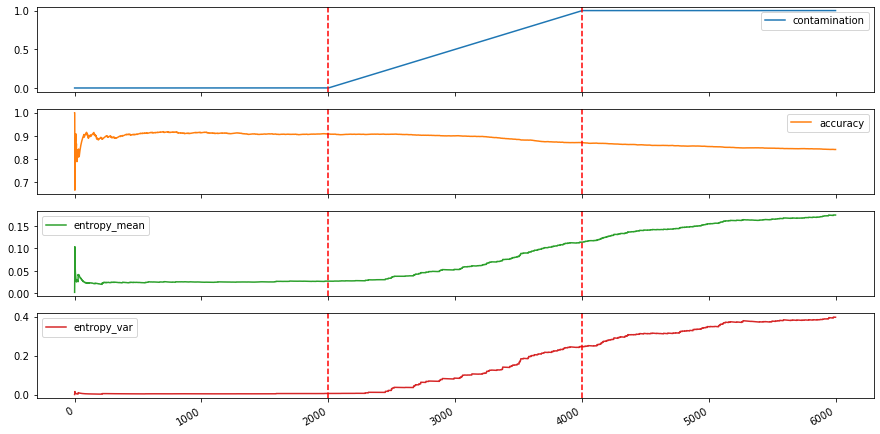

In [29]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

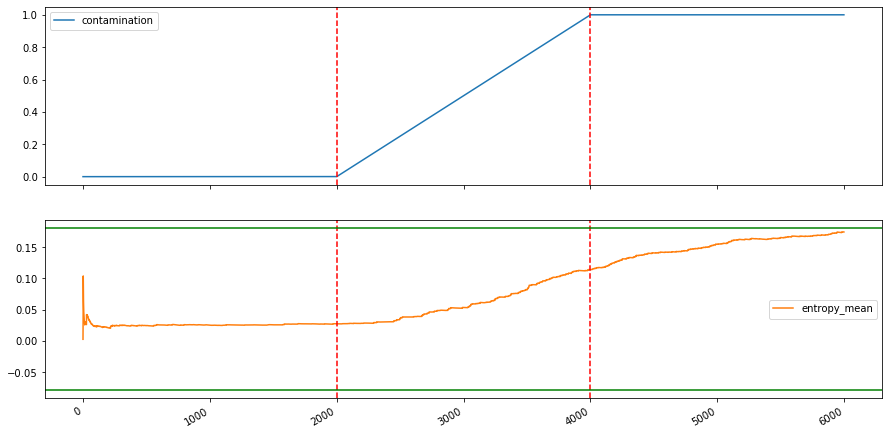

In [30]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus / amp, c='g')
axs[1].axhline(baseline_std_minus / amp, c='g')

In [31]:
data_stream = df['entropy_mean']
adwin = ADWIN(delta=0.002)
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < cd_start:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        elif i >= cd_start and i < cd_full:
            print(Fore.YELLOW + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))            
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.061417234996097636 - at index: 3135
Change detected in data: 0.0639467790399011 - at index: 3231
Change detected in data: 0.06757581749640992 - at index: 3263
Change detected in data: 0.07575851358128002 - at index: 3423
Change detected in data: 0.09207810401070375 - at index: 3583
Change detected in data: 0.108213096380459 - at index: 3839
Change detected in data: 0.11729857385392815 - at index: 4063
Change detected in data: 0.11959118640570174 - at index: 4127
Change detected in data: 0.1322382449137482 - at index: 4287
Change detected in data: 0.1399505905015677 - at index: 4479
Change detected in data: 0.14229596482083015 - at index: 4671
Change detected in data: 0.1619077305355806 - at index: 5215
Change detected in data: 0.1672540726024116 - at index: 5631
Change detected in data: 0.1740900281518451 - at index: 5951


---

# Old

In [1]:
import sys
import tensorflow as tf
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import svm
from keras.utils import to_categorical

/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: 

In [43]:
sys.path.append('../odcd/cd/')
sys.path.append('../odcd/utils/')

In [44]:
from importlib import reload

In [45]:
import model_symmetries as vsf

In [48]:
import streaming_sim_test as sst

# data prep

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

# define train and test set
np.random.seed(0)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)

idxs_train_0_5 = np.where((y_train == 5) | (y_train == 4) | (y_train == 3) | 
                    (y_train == 2) | (y_train == 1) | (y_train == 0))
idxs_test_0_5 = np.where((y_test == 5) | (y_test == 4) | (y_test == 3) | 
                    (y_test == 2) | (y_test == 1) | (y_test == 0))

idxs_train_6_9 = np.where((y_train == 6) | (y_train == 7) | (y_train == 8) | 
                    (y_train == 9))
idxs_test_6_9 = np.where((y_test == 6) | (y_test == 7) | (y_test == 8) | 
                    (y_test == 9))

print(idxs_train_0_5[0].shape)
print(idxs_test_0_5[0].shape)

x_train_0_5 = x_train[idxs_train_0_5[0]]
y_train_0_5 = y_train[idxs_train_0_5[0]]

x_train_6_9 = x_train[idxs_train_6_9[0]]
y_train_6_9 = y_train[idxs_train_6_9[0]]

print(x_train_0_5.shape, x_train_6_9.shape)
print(y_train_0_5.shape, y_train_6_9.shape)
idxs_test_0_5 = np.where((y_test == 5) | (y_test == 4) | (y_test == 3) | 
                    (y_test == 2) | (y_test == 1) | (y_test == 0))
x_test_0_5 = x_test[idxs_test_0_5[0]]

x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
(36017,)
(6031,)
(36017, 28, 28, 1) (23983, 28, 28, 1)
(36017,) (23983,)


In [6]:
x_train = x_train_0_5
y_train = y_train_0_5
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)
y_train = to_categorical(y_train)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

y_train shape: (36017,) y_test shape: (10000,)
y_train shape: (36017, 6) y_test shape: (10000,)


# Model

In [7]:
import numpy as np
import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from keras.models import Model
from keras.utils import to_categorical

In [8]:
def superpixel(image, size=(4, 7)):
    import numpy as np
    segments = np.zeros([image.shape[0], image.shape[1]])
    row_idx, col_idx = np.where(segments == 0)
    for i, j in zip(row_idx, col_idx):
        segments[i, j] = int((image.shape[1]/size[1]) * (i//size[0]) + j//size[1])
    return segments


# define and  train an cnn model
def model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(6, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn


cnn = model()
cnn.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxP

In [9]:
print('Training cnn ...')
cnn.fit(x_train, y_train, batch_size=64, epochs=10)
print('Training done!')

Training cnn ...
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
36017/36017 [==============================] - 22s 624us/step - loss: 0.1956 - acc: 0.9359
Epoch 2/10
36017/36017 [==============================] - 24s 671us/step - loss: 0.0600 - acc: 0.9807
Epoch 3/10
36017/36017 [==============================] - 23s 644us/step - loss: 0.0455 - acc: 0.9854
Epoch 4/10
36017/36017 [==============================] - 24s 661us/step - loss: 0.0377 - acc: 0.9877
Epoch 5/10
36017/36017 [==============================] - 25s 694us/step - loss: 0.0303 - acc: 0.9904
Epoch 6/10
36017/36017 [==============================] - 26s 724us/step - loss: 0.0274 - acc: 0.9907
Epoch 7/10
36017/36017 [==============================] - 27s 752us/step - loss: 0.0254 - acc: 0.9916
Epoch 8/10
36017/36017 [==============================] - 28s 784us/step - loss: 0.0235 - acc: 0.9924
Epoch 9/10
36017/36017 [==============================] - 26s 711us/step - loss: 0.0205 - acc: 0.9929
Epoch 10/10
36017

In [10]:
cnn.save("cnn.h5")

# Vae

In [11]:
isinstance(cnn, keras.models.Model)

True

In [12]:
clf = tf.keras.models.load_model('cnn.h5')

In [13]:
reload(vsf)

<module 'model_symmetries' from '../odcd/cd/model_symmetries.py'>

In [20]:
vae = vsf.VaeSymmetryFinder(clf, input_shape=(28, 28, 1), intermediate_dim=128, latent_dim=4)

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 784)          0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          100480      reshape_1[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 4)            516         dense_3[0][0]                    
__________________________________________________________________________________________________
z_log_

In [21]:
x = x_train[:1]

In [22]:
clf.predict(x)

array([[1.4357335e-08, 8.6509425e-07, 4.6784795e-08, 6.7305349e-02,
        3.5986893e-08, 9.3269372e-01]], dtype=float32)

In [23]:
vae.predict_original(x)

array([[1.4357335e-08, 8.6509425e-07, 4.6784795e-08, 6.7305349e-02,
        3.5986893e-08, 9.3269372e-01]], dtype=float32)

In [24]:
vae.fit(x_train, x_test=x_test_0_5, epochs=10)

Train on 36017 samples, validate on 6031 samples
Epoch 1/10
36017/36017 [==============================] - 21s 590us/sample - loss: 0.3487 - val_loss: 0.0842
Epoch 2/10
36017/36017 [==============================] - 24s 670us/sample - loss: 0.0992 - val_loss: 0.0523
Epoch 3/10
36017/36017 [==============================] - 26s 725us/sample - loss: 0.0769 - val_loss: 0.0473
Epoch 4/10
36017/36017 [==============================] - 24s 680us/sample - loss: 0.0593 - val_loss: 0.0351
Epoch 5/10
36017/36017 [==============================] - 26s 735us/sample - loss: 0.0565 - val_loss: 0.0451
Epoch 6/10
36017/36017 [==============================] - 31s 856us/sample - loss: 0.0478 - val_loss: 0.0359
Epoch 7/10
36017/36017 [==============================] - 29s 819us/sample - loss: 0.0431 - val_loss: 0.0364
Epoch 8/10
36017/36017 [==============================] - 30s 839us/sample - loss: 0.0437 - val_loss: 0.0358
Epoch 9/10
36017/36017 [==============================] - 31s 866us/sample - lo

Sample instance from the MNIST data set.


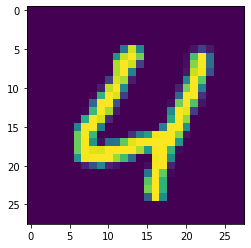

In [25]:
idx = 39
x = x_train[idx: idx + 1]
plt.imshow(np.squeeze(x))
print('Sample instance from the MNIST data set.')

In [26]:
outs_1 = vae.vae.predict(x)
outs_2 = vae.vae.predict(x)

In [27]:
symmetric_sample_1 = outs_1[0]
symmetric_sample_2 = outs_2[0]

orig_pred_1 = outs_1[1]
orig_pred_2 = outs_2[1]

trans_pred_1 = outs_1[2]
trans_pred_2 = outs_2[2]

In [28]:
orig_pred_1

array([[1.5582623e-07, 1.3442530e-09, 1.1437270e-08, 7.0882493e-12,
        9.9999988e-01, 1.6098614e-12]], dtype=float32)

In [29]:
trans_pred_1

array([[1.9093161e-04, 2.3385980e-04, 5.9512525e-04, 3.5031615e-05,
        9.9875486e-01, 1.9012360e-04]], dtype=float32)

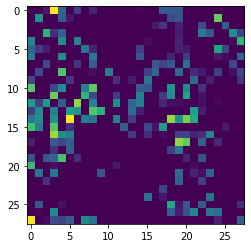

In [30]:
plt.imshow(np.squeeze(symmetric_sample_1))

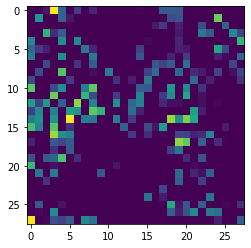

In [31]:
plt.imshow(np.squeeze(symmetric_sample_2))

# Test as concept drift detector

In [32]:
from scipy.ndimage import rotate
import pandas as pd
from scipy.stats import entropy

In [33]:
y_test.shape

(10000,)

In [34]:
x_test_0_5.shape

(6031, 28, 28, 1)

In [35]:
x_test_0_5 = x_test[idxs_test_0_5[0]]
y_test_0_5 = y_test[idxs_test_0_5[0]]

In [36]:
vae_outs_train = vae.vae.predict(x_train.reshape(x_train.shape[0], 28, 28, 1))
vae_outs_bl = vae.vae.predict(x_test_0_5.reshape(x_test_0_5.shape[0], 28, 28, 1))

In [37]:
symm_samples_train = vae_outs_train[0]
orig_preds_train = vae_outs_train[1]
trans_preds_train = vae_outs_train[2]

symm_samples_bl = vae_outs_bl[0]
orig_preds_bl = vae_outs_bl[1]
trans_preds_bl = vae_outs_bl[2]

In [38]:
kl_train = entropy(orig_preds_train.T, trans_preds_train.T)
kl_bl = entropy(orig_preds_bl.T, trans_preds_bl.T)

In [39]:
preds_train = np.argmax(orig_preds_train, axis=1)
labels_train = np.argmax(y_train, axis=1)
from sklearn.metrics import accuracy_score
acc_train = accuracy_score(preds_train, labels_train)
print(acc_train)

preds_bl = np.argmax(orig_preds_bl, axis=1)
from sklearn.metrics import accuracy_score
acc_bl = accuracy_score(preds_bl, y_test_0_5)
print(acc_bl)

0.998889413332593
0.996683800364782


### Rotations

In [40]:
vae_outs_test = vae.vae.predict(x_test_0_5)
symm_samples_test = vae_outs_test[0]
orig_preds_test = vae_outs_test[1]
trans_preds_test = vae_outs_test[2]
    
kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
baseline_std_plus = kl_test.mean() + kl_test.std()
baseline_std_minus = kl_test.mean() - kl_test.std()

In [99]:
mean_test = []
std_test = []
accs_test = []
baseline_stds_plus = []
baseline_stds_minus = []
for i in range(45):
    
    print('Rotating images by {} degree'.format(i))
    x_test_0_5_rot = rotate(x_test_0_5, i, axes=(1, 2), reshape=False)
    
    vae_outs_test = vae.vae.predict(x_test_0_5_rot.reshape(x_test_0_5_rot.shape[0], 28, 28, 1))
    symm_samples_test = vae_outs_test[0]
    orig_preds_test = vae_outs_test[1]
    trans_preds_test = vae_outs_test[2]
    
    kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
    mean_test.append(kl_test.mean())
    std_test.append(kl_test.std())
    preds_test = np.argmax(orig_preds_test, axis=1)
    accs_test.append(accuracy_score(preds_test, y_test_0_5))
    baseline_stds_plus.append(baseline_std_plus)
    baseline_stds_minus.append(baseline_std_minus)

Rotating images by 0 degree
Rotating images by 1 degree
Rotating images by 2 degree
Rotating images by 3 degree
Rotating images by 4 degree
Rotating images by 5 degree
Rotating images by 6 degree
Rotating images by 7 degree
Rotating images by 8 degree
Rotating images by 9 degree
Rotating images by 10 degree
Rotating images by 11 degree
Rotating images by 12 degree
Rotating images by 13 degree
Rotating images by 14 degree
Rotating images by 15 degree
Rotating images by 16 degree
Rotating images by 17 degree
Rotating images by 18 degree
Rotating images by 19 degree
Rotating images by 20 degree
Rotating images by 21 degree
Rotating images by 22 degree
Rotating images by 23 degree
Rotating images by 24 degree
Rotating images by 25 degree
Rotating images by 26 degree
Rotating images by 27 degree
Rotating images by 28 degree
Rotating images by 29 degree
Rotating images by 30 degree
Rotating images by 31 degree
Rotating images by 32 degree
Rotating images by 33 degree
Rotating images by 34 de

In [100]:
df = pd.DataFrame()
df['accuracy'] = accs_test
df['entropy_mean'] = mean_test
df['entropy_std'] = std_test
df['baseline_std_plus'] = baseline_stds_plus
df['baseline_std_minus'] = baseline_stds_minus

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f95051da210>,
      dtype=object)

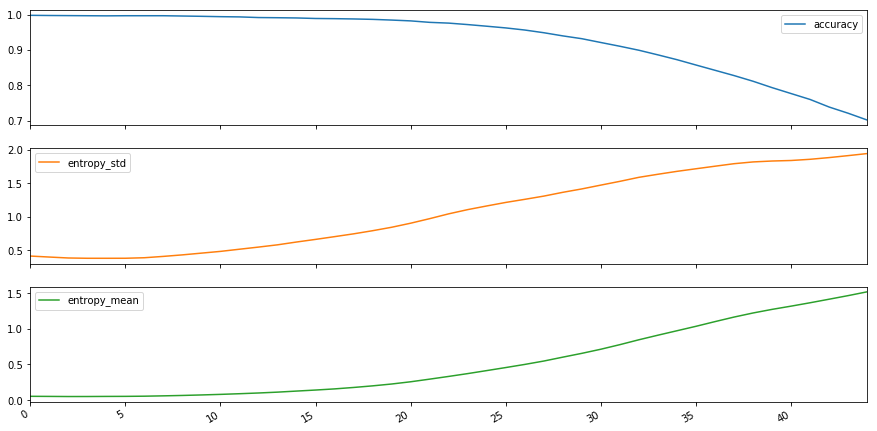

In [101]:
df[['accuracy','entropy_std','entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))

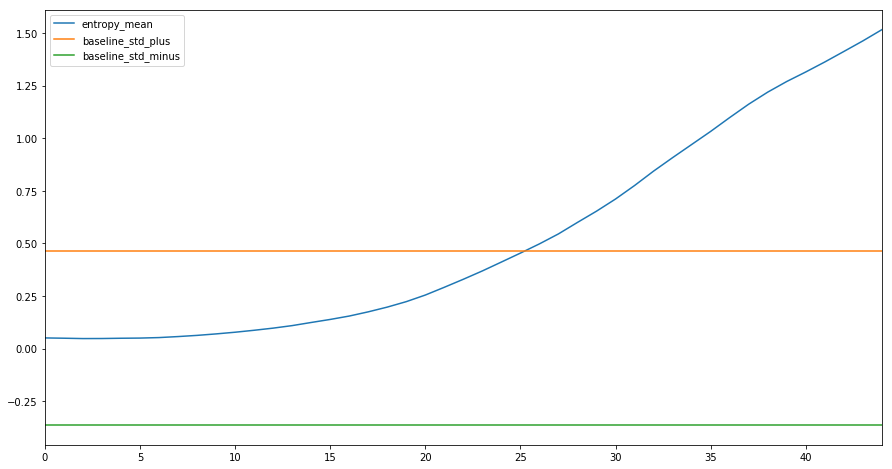

In [102]:
df[['entropy_mean', 'baseline_std_plus', 'baseline_std_minus']].plot(logy = False, subplots=False, figsize = (15, 8))

In [45]:
#df.plot(logy = False, subplots=True, figsize = (15, 8))

### Contamination

In [82]:
idx_test_6 = np.where(y_test == 6)
x_test_6 = x_test[idx_test_6]
x_test_6.shape
y_test_6 = y_test[idx_test_6]

In [84]:
rnd_idxs_6  = np.random.choice(range(len(x_test_6)), 10)
x_cont_6  = x_test_6[rnd_idxs_6]

In [86]:
mean_test = []
std_test = []
accs_test = []
baseline_stds_plus = []
baseline_stds_minus = []

for i in range(0, len(x_test_6), 15):
    rnd_idxs_6  = np.random.choice(range(len(x_test_6)), i)
    x_cont_6 = x_test_6[rnd_idxs_6]
    y_cont_6 = y_test_6[rnd_idxs_6]
    print('Number of contaminations: {} '.format(i))
    x_test_0_5_cont = np.concatenate((x_test_0_5, x_cont_6), axis=0)
    y_test_0_5_cont = np.concatenate((y_test_0_5, y_cont_6), axis=0)
    vae_outs_test = vae.vae.predict(x_test_0_5_cont.reshape(x_test_0_5_cont.shape[0], 28, 28, 1))
    symm_samples_test = vae_outs_test[0]
    orig_preds_test = vae_outs_test[1]
    trans_preds_test = vae_outs_test[2]
    
    kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
    mean_test.append(kl_test.mean())
    std_test.append(kl_test.std())
    preds_test = np.argmax(orig_preds_test, axis=1)
    accs_test.append(accuracy_score(preds_test, y_test_0_5_cont))
    baseline_stds_plus.append(baseline_std_plus)
    baseline_stds_minus.append(baseline_std_minus)

Number of contaminations: 0 
Number of contaminations: 15 
Number of contaminations: 30 
Number of contaminations: 45 
Number of contaminations: 60 
Number of contaminations: 75 
Number of contaminations: 90 
Number of contaminations: 105 
Number of contaminations: 120 
Number of contaminations: 135 
Number of contaminations: 150 
Number of contaminations: 165 
Number of contaminations: 180 
Number of contaminations: 195 
Number of contaminations: 210 
Number of contaminations: 225 
Number of contaminations: 240 
Number of contaminations: 255 
Number of contaminations: 270 
Number of contaminations: 285 
Number of contaminations: 300 
Number of contaminations: 315 
Number of contaminations: 330 
Number of contaminations: 345 
Number of contaminations: 360 
Number of contaminations: 375 
Number of contaminations: 390 
Number of contaminations: 405 
Number of contaminations: 420 
Number of contaminations: 435 
Number of contaminations: 450 
Number of contaminations: 465 
Number of contam

In [89]:
df = pd.DataFrame()
df['accuracy'] = accs_test
df['entropy_mean'] = mean_test
df['entropy_std'] = std_test
df['baseline_std_plus'] = baseline_stds_plus
df['baseline_std_minus'] = baseline_stds_minus

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9505356190>,
      dtype=object)

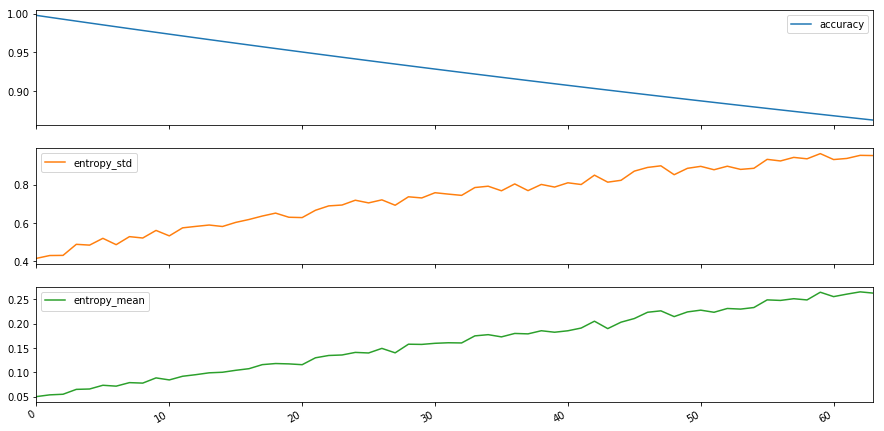

In [98]:
df[['accuracy','entropy_std','entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))

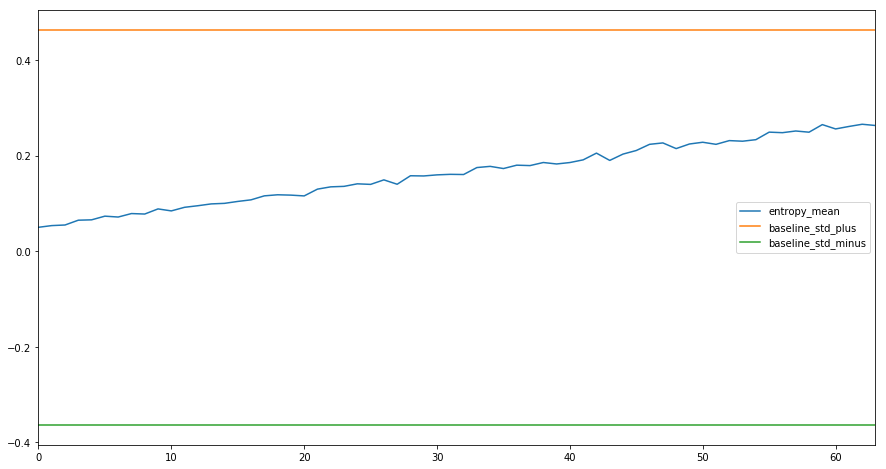

In [91]:
df[['entropy_mean', 'baseline_std_plus', 'baseline_std_minus']].plot(logy = False, subplots=False, figsize = (15, 8))

In [92]:
#df = pd.DataFrame()
#df['accuracy'] = accs_test
#df['entropy_mean'] = mean_test
#df['entropy_std'] = std_test

In [93]:
#df.plot(logy = False, subplots=True, figsize = (15, 8))

In [97]:
df

,accuracy,entropy_mean,entropy_std,baseline_std_plus,baseline_std_minus
0,0.997679,0.049989,0.414312,0.463379,-0.363646
1,0.995203,0.053553,0.429154,0.463379,-0.363646
2,0.992740,0.054804,0.429856,0.463379,-0.363646
3,0.990290,0.064843,0.487890,0.463379,-0.363646
4,0.987851,0.065614,0.483721,0.463379,-0.363646
...,...,...,...,...,...
59,0.870012,0.264802,0.963613,0.463379,-0.363646
60,0.868129,0.255759,0.932522,0.463379,-0.363646
61,0.866254,0.260910,0.938378,0.463379,-0.363646
62,0.864387,0.265555,0.954578,0.463379,-0.363646


In [42]:
kl_test.mean()

0.17890525

# Stream Contamination

### Rolling one by one

In [41]:
cd_start = 5000
cd_full = 2 * cd_start
nb_samples_tot = 15000
start = 100

In [52]:
reload(sst)

<module 'streaming_sim_test' from '../odcd/utils/streaming_sim_test.py'>

In [53]:
df = sst.rolling_stats(vae, x_test_0_5, y_test_0_5, x_train_6_9, y_train_6_9, cd_start, nb_samples_tot, start)

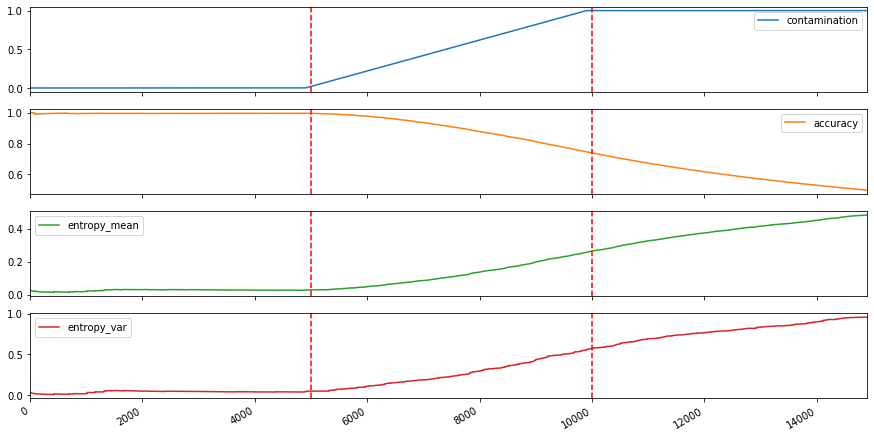

In [54]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

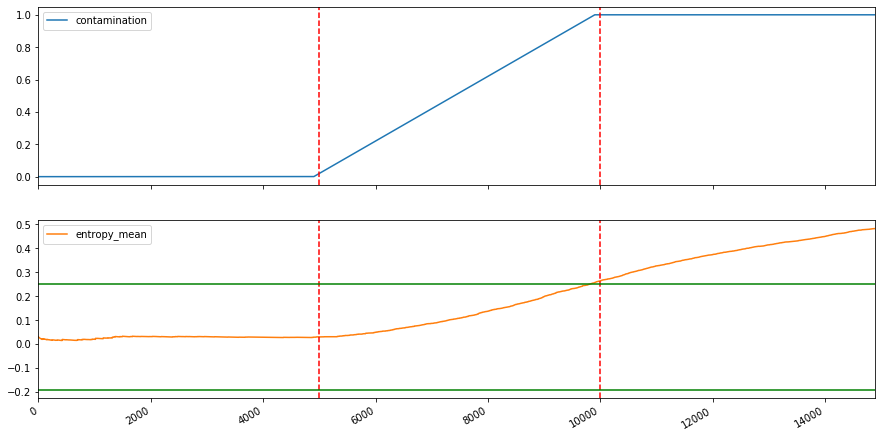

In [55]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus, c='g')
axs[1].axhline(baseline_std_minus, c='g')

In [57]:
import seaborn as sns

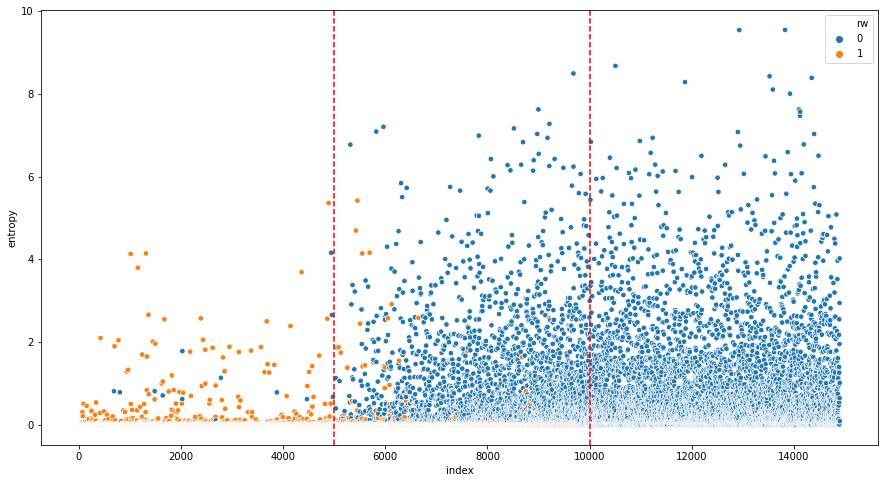

In [58]:
plt.figure(figsize=(15,8))
sns.scatterplot( x="index", y="entropy", data=df.reset_index(), s=30, hue='rw')
ax.set(ylim=(-0.1, None))
plt.axvline(cd_start, c='r', linestyle='dashed')
plt.axvline(cd_full, c='r', linestyle='dashed')

### Rolling window

In [59]:
cd_start = 5000
nb_samples_tot = 15000
start = 0
window_size = 500

In [68]:
df, window_start, window_full = sst.sliding_window(vae, x_test_0_5, y_test_0_5, x_train_6_9, y_train_6_9, window_size, cd_start, nb_samples_tot, start)

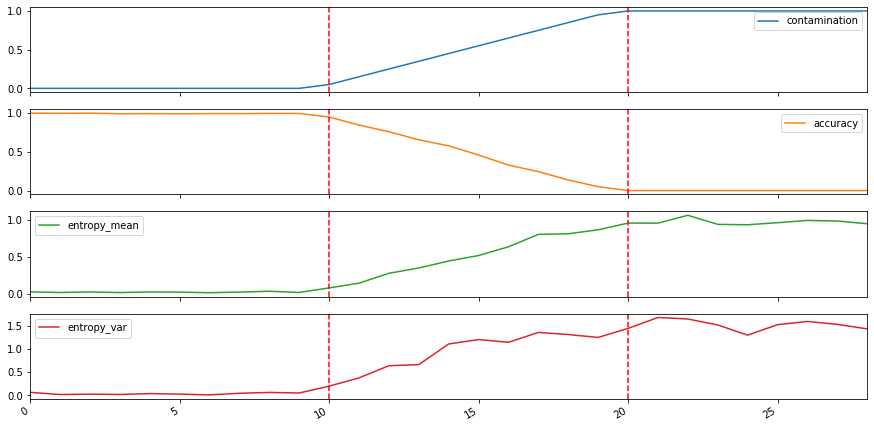

In [69]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(window_start, c='r', linestyle='dashed')
    ax.axvline(window_full, c='r', linestyle='dashed')

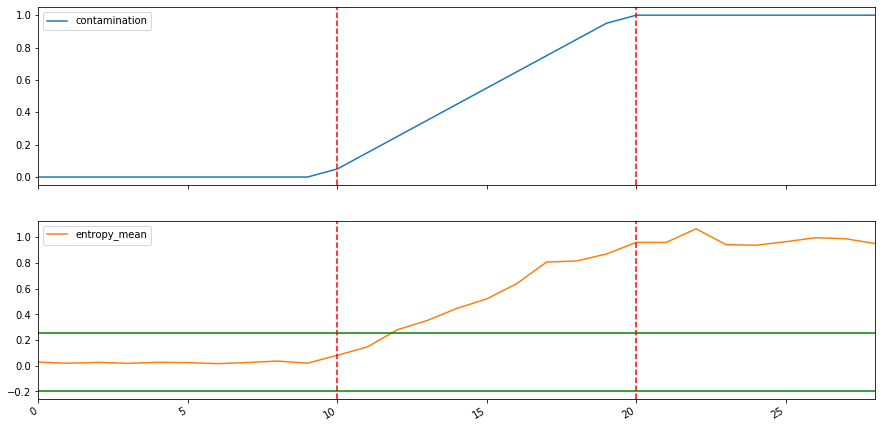

In [70]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(window_start, c='r', linestyle='dashed')
    ax.axvline(window_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus, c='g')
axs[1].axhline(baseline_std_minus, c='g')

# Cherry pick

In [49]:
preds_test = np.argmax(clf.predict(x_test_0_5), axis=1)
preds_test

array([2, 1, 0, ..., 3, 4, 5])

In [55]:
idx_miss = np.where(preds_test != y_test_0_5)

In [59]:
x_miss = x_test_0_5[idx_miss]

In [60]:
vae_outs_train = vae.vae.predict(x_test_0_5.reshape(x_test_0_5.shape[0], 28, 28, 1))
vae_outs_test = vae.vae.predict(x_miss.reshape(x_miss.shape[0], 28, 28, 1))

symm_samples_train = vae_outs_train[0]
orig_preds_train = vae_outs_train[1]
trans_preds_train = vae_outs_train[2]

symm_samples_test = vae_outs_test[0]
orig_preds_test = vae_outs_test[1]
trans_preds_test = vae_outs_test[2]

In [61]:
kl_train = entropy(orig_preds_train.T, trans_preds_train.T)
kl_test = entropy(orig_preds_test.T, trans_preds_test.T)

In [62]:
S_train = pd.Series(kl_train, name='train')
S_test = pd.Series(kl_test, name='test')
df_kl = pd.merge(S_train.to_frame(), S_test.to_frame(), right_index=True, left_index=True, how='outer')

0.03827944025397301 0.30201488733291626
1.4426838159561157 1.7499723434448242


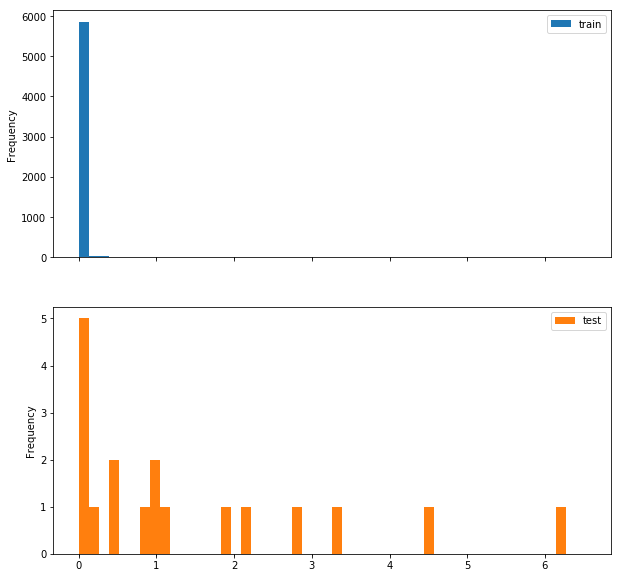

In [63]:
df_kl.plot(kind='hist', bins=50, subplots=True, figsize=(10, 10))
print(S_train.mean(), S_train.std())
print(S_test.mean(), S_test.std())

In [64]:
S_test

0     0.055232
1     0.985691
2     3.308836
3     0.799344
4     4.443614
5     2.094492
6     0.083315
7     1.148329
8     0.028951
9     0.428228
10    0.142924
11    0.033493
12    0.920331
13    1.905113
14    0.090810
15    2.762497
16    6.239838
17    0.497271
Name: test, dtype: float32

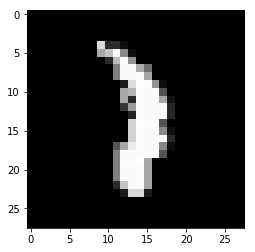

In [67]:
plt.imshow(np.squeeze(x_miss[2]), 'gray')

In [ ]:
y